# Goals

This notebook demonstrates how to use `skpro`'s `BayesianLinearRegressor`, which performs Bayesian linear regression powered by `PyMC` as the backend. The model defaults to weakly informative priors for both the intercept and slope, providing a flexible framework for capturing uncertainty in parameter estimates.

In addition to showcasing the `BayesianLinearRegressor`, this notebook also revisits key aspects of the Bayesian workflow, its underlying theory and its comparison with the traditional Ordinary Least Squares (OLS) regression. 

Note: this notebook requires Python `>= 3.10` to run.

## Problem Statement

In this exercise, we aim to compare the performance of OLS and Bayesian Linear Regression by training both models on the same synthetic dataset and analyzing their results.

We will see that compared to OLS regression, Bayesian Linear Regression offers several key advantages:

1. **Incorporation of Prior Knowledge**: Bayesian regression allows you to incorporate prior beliefs about parameters, which can improve estimates, especially in cases where data is sparse.

2. **Uncertainty Quantification**: It provides full posterior distributions for model parameters, enabling an intuitive assessment of uncertainty in predictions.

# Imports and Helper Function

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import statsmodels.api as sm
from IPython.display import Math, display
from pymc_marketing.prior import Prior

from skpro.regression.bayesian import BayesianLinearRegressor

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def style_df(df, vmax=None, subset=None, cmap="coolwarm", hide_index=False):
    """
    Helper function - apply styling to a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to style.
    vmax : float, optional
        The maximum numeric value for the color spectrum.
        Defaults to the max value in the DataFrame.
    subset : list, optional
        List of columns to which the gradient coloring/formatting is to be applied.
    cmap : str, optional
        The color map to apply for the gradient. Defaults to 'coolwarm'.
    hide_index : bool, optional
        If True, hide the DataFrame index in the output. Defaults to False.

    Returns
    -------
    pd.io.formats.style.Styler
        The styled DataFrame.
    """
    # Determine the max value for the gradient if not provided
    if vmax is None:
        vmax = df.select_dtypes(include=["number"]).max().max()

    # If no subset provided, apply to all float columns by default
    if subset is None:
        subset = pd.IndexSlice[:, df.select_dtypes(include=["float64"]).columns]

    # Apply background gradient to numeric columns and format to 3 decimal points
    styled_df = df.style.background_gradient(
        cmap=cmap, axis=None, vmin=-vmax, vmax=vmax, subset=subset
    ).format("{:.3f}", subset=subset)

    # Handle boolean columns with specific coloring (pink for False, lightblue for True)
    bool_columns = df.select_dtypes(include=["bool"]).columns

    def color_boolean(val):
        color = "lightblue" if val else "pink"
        return f"background-color: {color}"

    # Apply the boolean-specific styling if any boolean columns exist
    if not bool_columns.empty:
        styled_df = styled_df.applymap(color_boolean, subset=bool_columns)

    # Hide the index if hide_index is True
    if hide_index:
        styled_df = styled_df.hide(axis="index")

    return styled_df

# Data 

We will first create synthetic data with just two features (`feature1` and `feature2`) and 20 data points. The true relationship between the data $\mathbf{x}$ and the target variable ($y_{\text{true}}$) is given by the equation:

\begin{equation}
y_{\text{true}} = \text{intercept}_{\text{true}} + \mathbf{x} \cdot \mathbf{m}_{\text{true}}
\end{equation}


where $\text{intercept}_{\text{true}} = 1$ and $\mathbf{m}_{\text{true}} = [2, 3]$.

The observed target values ($y_{\text{train}}$) are generated by adding Gaussian noise to the true target values:

\begin{equation}
y = y_{\text{true}} + \mathcal{N}(0, \sigma_{\text{true}})
\end{equation}
Here, $\sigma_{\text{true}} = 0.5$.


In [4]:
N = 20
np.random.seed(42)

# Creating 10 random data points containing 2 features
feature1 = np.random.uniform(0, 1, N)
feature2 = np.random.uniform(0, 1, N)
X_train = pd.DataFrame({"feature1": feature1, "feature2": feature2})

# Set the relationship between the features and the target variable
TRUE_INTERCEPT = 1
TRUE_SLOPES = np.array([2, 3])
TRUE_SIGMA = 0.5

# Calculating the true target variable
y_true = TRUE_INTERCEPT + np.dot(X_train, TRUE_SLOPES)

y_train = y_true + np.random.normal(0, TRUE_SIGMA, size=len(X_train))

# Combine the features and targets into a single DataFrame
train_data = pd.concat(
    [X_train, pd.Series(y_true, name="y_true"), pd.Series(y_train, name="y_train")],
    axis=1,
)
train_data = train_data.sort_values(by="feature1")
train_data = train_data.reset_index(drop=True)

# Display the train_data DataFrame
style_df(train_data.head())

,feature1,feature2,y_true,y_train
0,0.021,0.608,2.864,2.806
1,0.058,0.200,1.715,1.051
2,0.156,0.785,3.668,2.688
3,0.156,0.456,2.680,2.785
4,0.182,0.966,4.261,4.030


The line chart below plots the relationship between `feature1` and the targets - both the theoretical `y_true`, represented by the red line, and the observed `y_train`, represented by the blue dots.

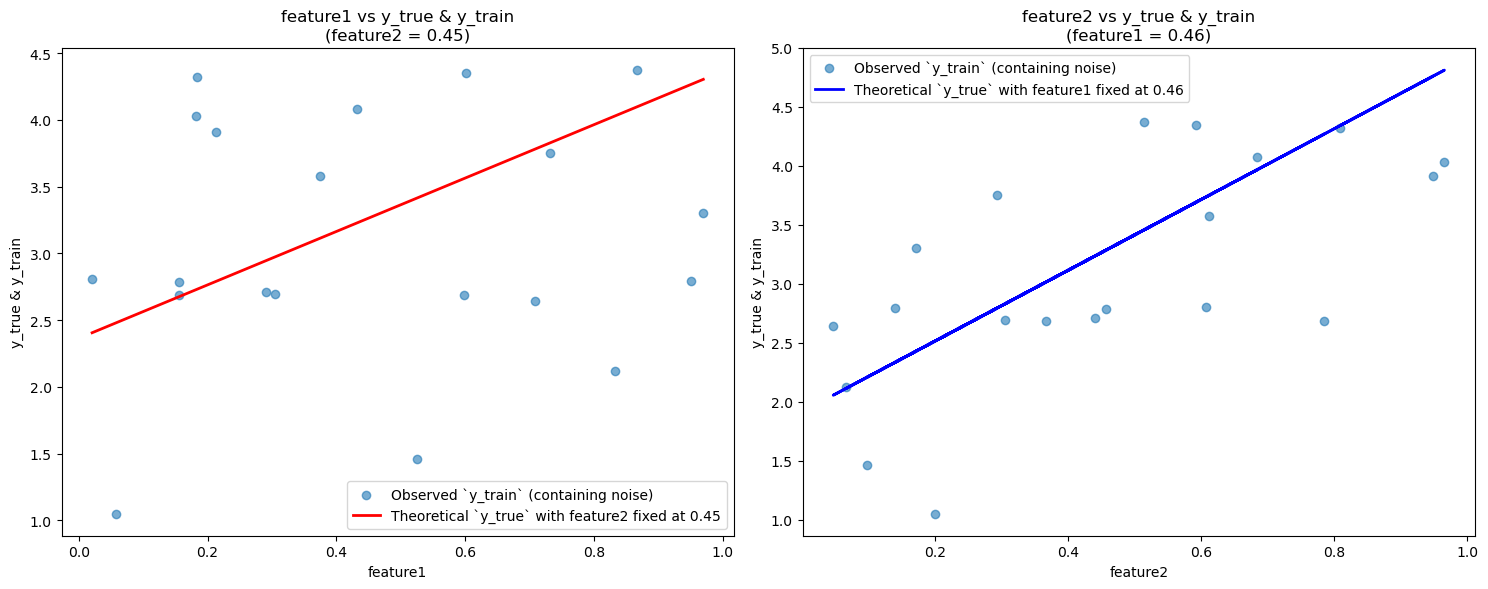

In [5]:
# Fix feature1 and feature2 constants
feature1_constant = train_data["feature1"].mean()
feature2_constant = train_data["feature2"].mean()

# Recalculate the true target `y_true` for a constant feature1
y_true_fixed_feature1 = (
    TRUE_INTERCEPT
    + TRUE_SLOPES[0] * feature1_constant
    + TRUE_SLOPES[1] * train_data["feature2"]
)

# Recalculate the true target `y_true` for a constant feature2
y_true_fixed_feature2 = (
    TRUE_INTERCEPT
    + TRUE_SLOPES[0] * train_data["feature1"]
    + TRUE_SLOPES[1] * feature2_constant
)

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot feature1 vs. y_train with feature2 constant
axes[0].scatter(
    train_data["feature1"],
    train_data["y_train"],
    label="Observed `y_train` (containing noise)",
    alpha=0.6,
)
axes[0].plot(
    train_data["feature1"],
    y_true_fixed_feature2,
    color="red",
    label=f"Theoretical `y_true` with feature2 fixed at {feature2_constant:.2f}",
    linewidth=2,
)
axes[0].set_xlabel("feature1")
axes[0].set_ylabel("y_true & y_train")
axes[0].set_title(f"feature1 vs y_true & y_train\n(feature2 = {feature2_constant:.2f})")
axes[0].legend()

# Plot feature2 vs. y_train with feature1 constant
axes[1].scatter(
    train_data["feature2"],
    train_data["y_train"],
    label="Observed `y_train` (containing noise)",
    alpha=0.6,
)
axes[1].plot(
    train_data["feature2"],
    y_true_fixed_feature1,
    color="blue",
    label=f"Theoretical `y_true` with feature1 fixed at {feature1_constant:.2f}",
    linewidth=2,
)
axes[1].set_xlabel("feature2")
axes[1].set_ylabel("y_true & y_train")
axes[1].set_title(f"feature2 vs y_true & y_train\n(feature1 = {feature1_constant:.2f})")
axes[1].legend()

# Improve spacing and show plot
plt.tight_layout()
plt.show()

We will also create synthetic **testing** data to evaluate the models' performance. The following code generates 10 new testing data points.

In [6]:
# Generate new data points for prediction with 2 features
N_test = 10
X_test = pd.DataFrame(
    {
        "feature1": np.random.uniform(0, 1, N_test),
        "feature2": np.random.uniform(0, 1, N_test),
    }
)

# Display the first few rows of X_test
style_df(X_test.head())

,feature1,feature2
0,0.075,0.358
1,0.987,0.116
2,0.772,0.863
3,0.199,0.623
4,0.006,0.331


# OLS Linear Regression: Theory

OLS is a method for estimating the linear relationship between independent variables (features) and a dependent variable (target).  The goal is to find a linear relationship by minimizing the sum of squared differences between the observed and predicted target values:

$$
\hat{\beta} = \arg\min_{\beta} \sum_{i=1}^n (y_i - \mathbf{x}_i^T \beta)^2
$$


# OLS Linear Regression: Model Fitting

## Using Normal Equation

## Using `statsmodels`

We’ll use the **`statsmodels`** library to train the OLS model. This will serve as a baseline for comparison with Bayesian Linear Regression.

In [7]:
# Fit a linear regression model using statsmodels
X_train_with_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_with_const).fit()

When fitted to the data, the `ols_model` uses maximum likelihood estimation (MLE) to find the best estimates for the model parameters. A limitation of this approach is that it only provides point estimates—specific values for the slope and intercept—without any indication of the uncertainty or distribution of these estimates.

The code below demonstrates how to extract these estimates from the `ols_model`. We see that the estimated slopes, intercept, and standard deviation are somewhat close to the true values we set during data generation.

In [8]:
# Predicted values for y_train
y_train_pred = ols_model.predict(X_train_with_const)
residuals = y_train_pred - y_train


# True model
true_model_latex = rf"""
\text{{True data generating model:}} \\
y_{{\text{{true}}}} = {TRUE_SLOPES[0]:.2f} \cdot x_1 +
{TRUE_SLOPES[1]:.2f} \cdot x_2 + {TRUE_INTERCEPT:.2f} \\
\text{{True standard deviation: }} \sigma = {TRUE_SIGMA:.2f}\\
"""

# Estimated model
estimated_model_latex = rf"""
\text{{Estimated MLE model:}} \\
\hat{{y}} = {ols_model.params.iloc[1]:.2f} \cdot x_1 +
{ols_model.params.iloc[2]:.2f} \cdot x_2 + {ols_model.params.iloc[0]:.2f} \\
\text{{Standard deviation of residuals: }} \hat{{\sigma}} = {residuals.std():.2f}
"""

# Displaying the results using LaTeX
display(Math(true_model_latex))
display(Math(estimated_model_latex))

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Using the trained `ols_model`,  we can also create point predictions on the unseen `X_test` along with the corresponding confidence interval.

The latter provides a range within which we expect the true parameter to lie with a certain level of confidence (e.g., 95%).

In this code, we fix **`feature2`** at its mean value to isolate and visualize the influence of **`feature1`** on the target variable. 



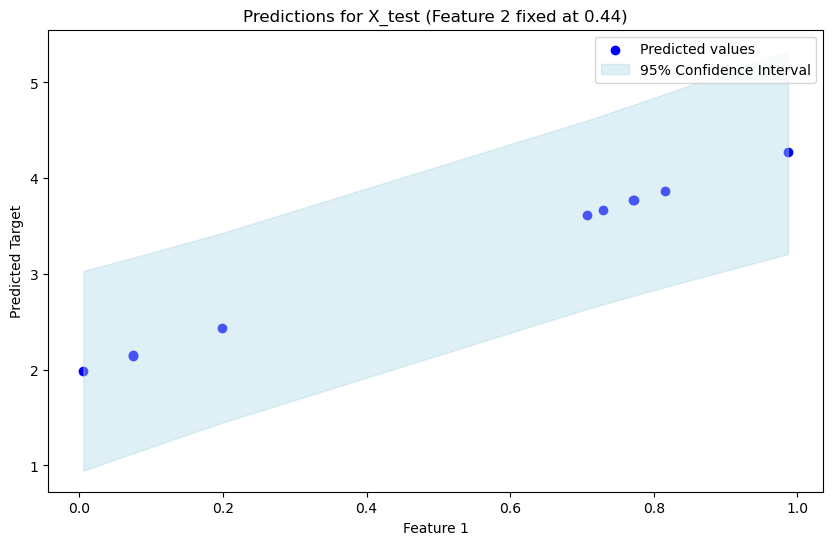

In [9]:
# Fix feature2 at its mean
feature2_constant = X_test["feature2"].mean()

# Create a new test dataset with feature2 fixed at the constant value
X_test_fixed_feature2 = X_test.copy()
X_test_fixed_feature2["feature2"] = feature2_constant

# Predict y_test using the linear model after adding constant
predictions_fixed_feature2 = ols_model.get_prediction(
    sm.add_constant(X_test_fixed_feature2, has_constant="add")
)
pred_summary_fixed_feature2 = predictions_fixed_feature2.summary_frame(alpha=0.05)

# Extract predicted values and confidence intervals
y_test_pred_fixed_feature2 = pred_summary_fixed_feature2["mean"]
conf_int_lower_fixed_feature2 = pred_summary_fixed_feature2["obs_ci_lower"]
conf_int_upper_fixed_feature2 = pred_summary_fixed_feature2["obs_ci_upper"]

sorted_indices = np.argsort(X_test["feature1"])
X_test_sorted = X_test["feature1"].iloc[sorted_indices]
y_test_pred_sorted = y_test_pred_fixed_feature2.iloc[sorted_indices]
conf_int_lower_sorted = conf_int_lower_fixed_feature2.iloc[sorted_indices]
conf_int_upper_sorted = conf_int_upper_fixed_feature2.iloc[sorted_indices]

# Plot the predictions with the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test_sorted, y_test_pred_sorted, color="blue", label="Predicted values")
plt.fill_between(
    X_test_sorted,
    conf_int_lower_sorted,
    conf_int_upper_sorted,
    color="lightblue",
    alpha=0.4,
    label="95% Confidence Interval",
)
plt.xlabel("Feature 1")
plt.ylabel("Predicted Target")
plt.title(f"Predictions for X_test (Feature 2 fixed at {feature2_constant:.2f})")
plt.legend()
plt.show()

# Bayesian Linear Regression: Theory

Now let's switch our attention to bayesian linear regression. Bayesian linear regression estimates the relationship between variables by incorporating prior knowledge or beliefs along with the observed data. Instead of providing single point estimates for the model parameters (like the slope and intercept), it calculates their probability distributions.

In this section, we will explore the theoretical framework used in Bayesian linear regression.

Bayesian linear regression directly applies Bayes' Theorem to estimate the posterior distributions of the model parameters. As a reminder, here is the Bayes Theorem:

\begin{align*}
P(\theta \mid D) &= \frac{P(D \mid \theta) \times P(\theta)}{P(D)} \\
\text{posterior} &= \frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}}
\end{align*}


Where:

- $\theta$ represents the model parameters, which in our case consist of the intercept $\beta_{0}$, the slopes $\beta$ and the noise $\sigma$
- $D$ represents the observed training data, which consist of $\mathbf{X}_{\text{train}}$ and  $\mathbf{y}_{\text{train}}$
- $P(\theta \mid D)$ is the posterior distribution of the parameters - given the data.
- $P(D \mid \theta)$ is the likelihood of the data given the parameters.
- $P(\theta)$ is the prior distribution of the parameters.
- $P(D)$ is the marginal likelihood (evidence), a normalizing constant ensuring the posterior is a valid probability distribution.



# Bayesian Linear Regression: Model Fitting

## Using Conjugate Prior

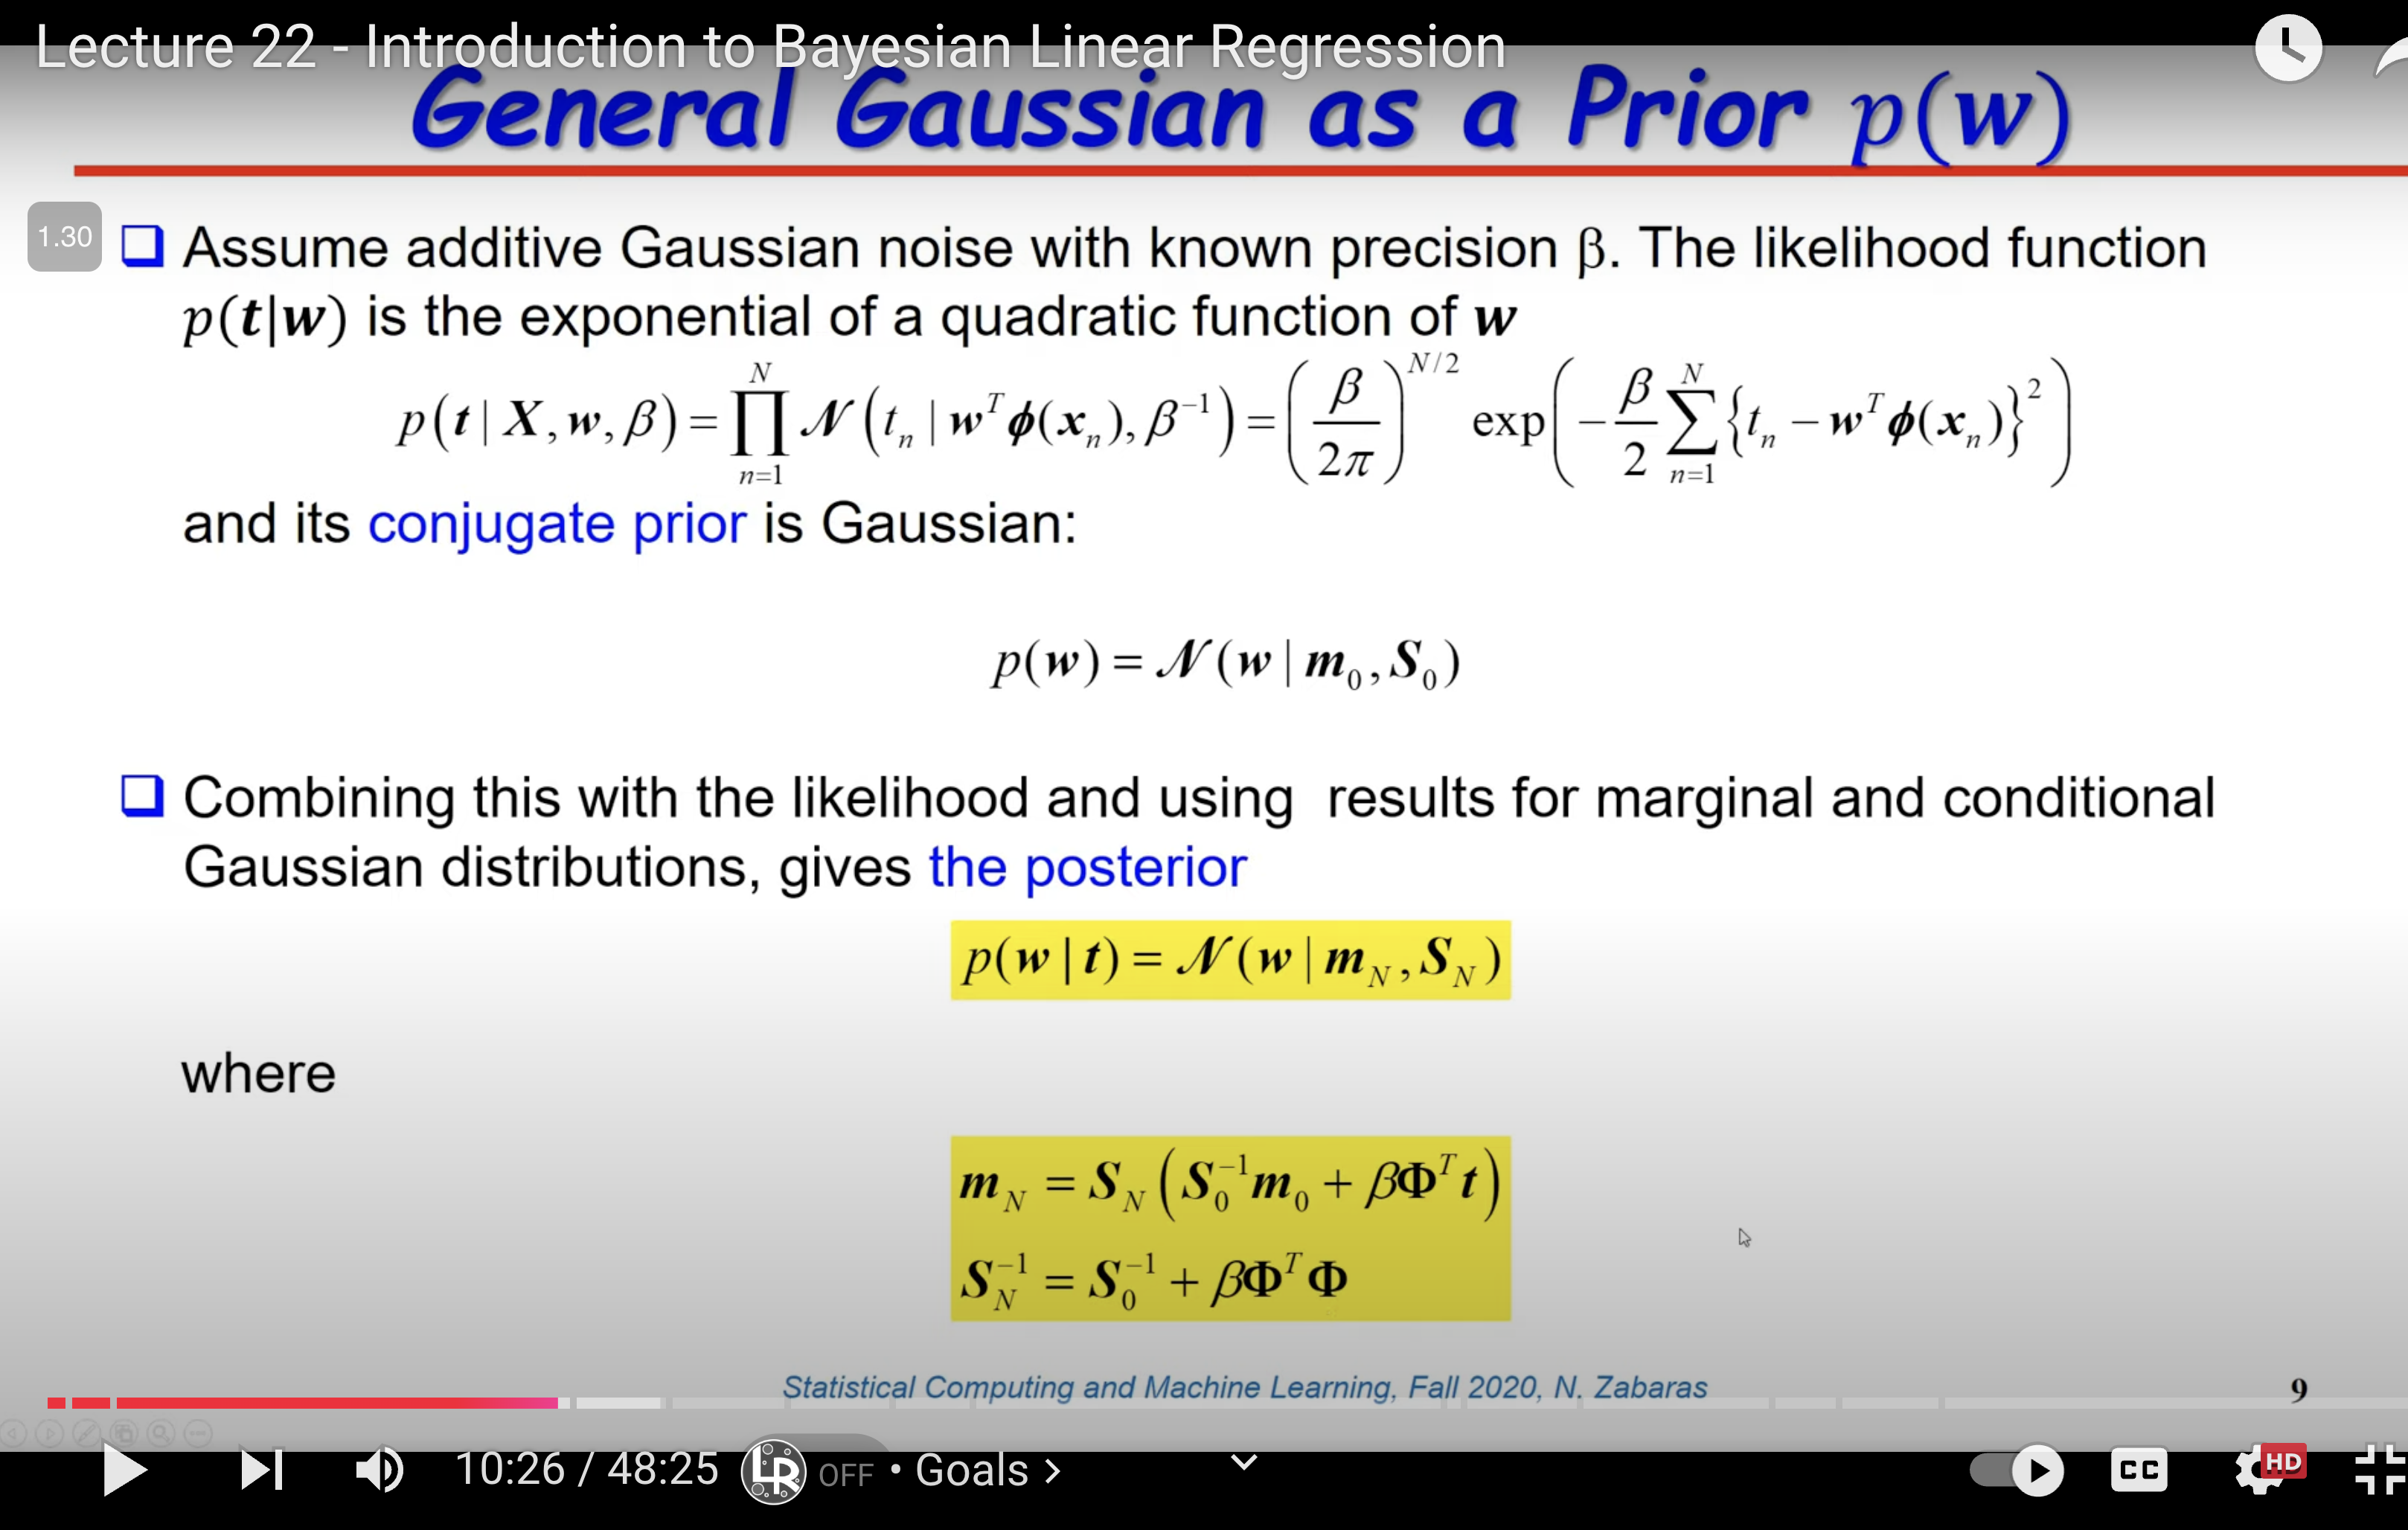

## Using MCMC

`skpro` provides an implementation of Bayesian linear regression through the `BayesianLinearRegressor` class. Here, we create an instance of the `BayesianLinearRegressor` and fit it to our training data.

In [10]:
# data conversion and renaming to facilitate downstream analysis
y_train = pd.DataFrame(y_train)
y_train.columns = ["target"]

In [11]:
%timeit
bayes_model = BayesianLinearRegressor()
bayes_model.fit(X_train, y_train)

The model assumes that the intercept and slopes are independent. 
            Modify the model if this assumption doesn't apply!
instantiated BayesianLinearRegressor with the following priors:
  - intercept: Prior("Normal", mu=0, sigma=100)
  - slopes: Prior("Normal", mu=0, sigma=100, dims="pred_id")
  - noise_var: Prior("HalfCauchy", beta=5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=0, sigma=100),
                                      'noise_var': Prior("HalfCauchy", beta=5),
                                      'slopes': Prior("Normal", mu=0, sigma=100, dims="pred_id")},
                        sampler_config={'chains': 2, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

## Prior

### Default Prior

The prior $P(\theta)$ reflects our beliefs about the parameters before observing any data. In Bayesian inference, the choice of prior can significantly impact the results, especially when the amount of data is limited.

In the case of **`BayesianLinearRegression`**, the model includes a default prior that is **weakly informative**. A weakly informative prior is designed to provide some structure without being overly restrictive or introducing strong assumptions. 

You can inspect these default priors by accessing the `default_prior_config` attribute of the model instance. This attribute will show the priors assigned to parameters like the intercept, slopes, and noise variance. 

In [12]:
bayes_model.default_prior_config

The model assumes that the intercept and slopes are independent. 
            Modify the model if this assumption doesn't apply!


{'intercept': Prior("Normal", mu=0, sigma=100),
 'slopes': Prior("Normal", mu=0, sigma=100, dims="pred_id"),
 'noise_var': Prior("HalfCauchy", beta=5)}

We see that they are as follows:

\begin{align*}
\text{intercept} &== \beta_{0} &\sim \mathcal{N}(0, 100) \\
\text{slopes} &== \beta &\sim \mathcal{N}(0, 100) \\
\text{noise} &== \sigma &\sim \text{HalfCauchy}(\beta=5)
\end{align*}


We can sample from these prior distributions using the `sample_prior` method of the `bayes_model`, specifying `numpy` arrays as the output format. The samples can then be plotted for visualization.

Sampling: [intercept, noise_var, slopes, y_obs]


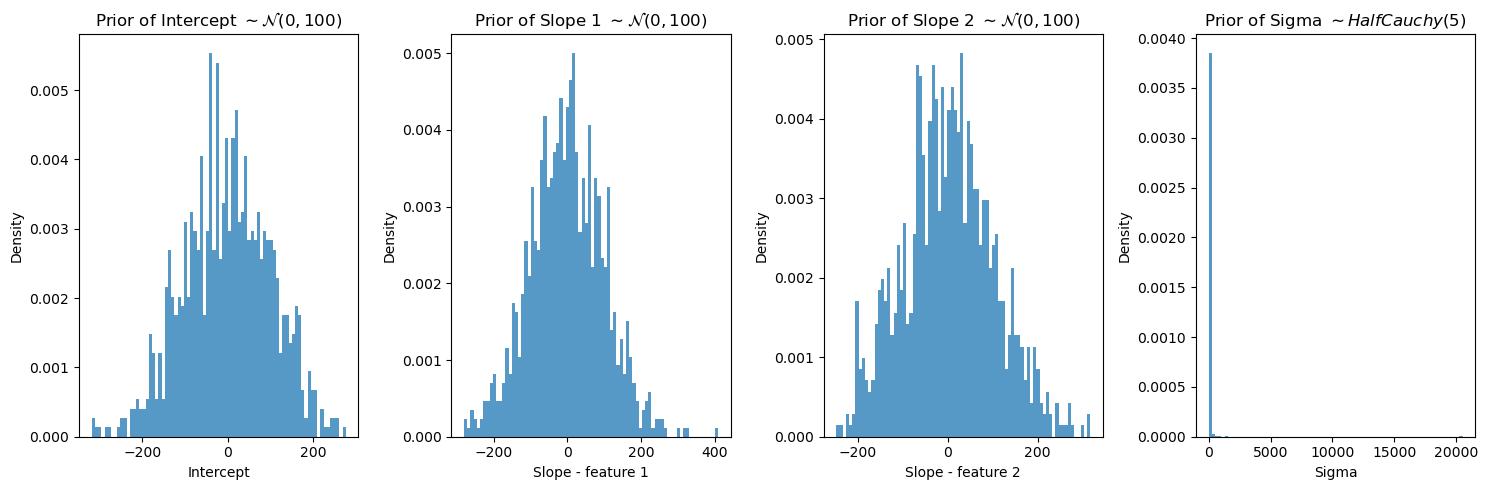

In [13]:
# get the prior samples as a dictionary of numpy arrays
prior_samples = bayes_model.sample_prior("numpy")

# Plot the prior distributions
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot prior for intercept
axes[0].hist(prior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].set_title(r"Prior of Intercept $\sim \mathcal{N}(0, 100)$")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")


# Plot prior for slopes
axes[1].hist(prior_samples["slopes_feature1"], bins=80, density=True, alpha=0.75)
axes[1].set_title(r"Prior of Slope 1 $\sim \mathcal{N}(0, 100)$")
axes[1].set_xlabel("Slope - feature 1")
axes[1].set_ylabel("Density")

axes[2].hist(prior_samples["slopes_feature2"], bins=80, density=True, alpha=0.75)
axes[2].set_title(r"Prior of Slope 2 $\sim \mathcal{N}(0, 100)$")
axes[2].set_xlabel("Slope - feature 2")
axes[2].set_ylabel("Density")


# Plot prior for sigma
axes[3].hist(prior_samples["noise_var"], bins=80, density=True, alpha=0.75)
axes[3].set_title(r"Prior of Sigma $\sim HalfCauchy(5)$")
axes[3].set_xlabel("Sigma")
axes[3].set_ylabel("Density")

plt.tight_layout()
plt.show()

Note that the method `sample_prior` that we use above can return us the samples in different data types. If we wish to, we could also ask for our priors an `skpro` distribution. 

Another convenient method is `get_prior_summary()` which calculates a summary statistics of our priors.

In [14]:
bayes_model.get_prior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.942,101.544,-186.723,177.891,3.257,2.304,974.0,975.0,NaN
slopes[feature1],-1.225,99.838,-203.817,173.313,3.252,2.344,941.0,875.0,NaN
slopes[feature2],2.958,100.046,-203.620,170.676,3.352,2.371,890.0,996.0,NaN
noise_var,39.432,653.651,0.014,45.035,20.613,14.591,1005.0,848.0,NaN
noise,3.170,5.423,0.201,6.714,0.170,0.121,1005.0,848.0,NaN


### Prior Elicitation

The default priors may not align with our beliefs, so we need to define priors that do. This process, known as **prior elicitation**, involves crafting priors that reflect domain knowledge. 


We'll use **PreliZ**, a library in the PyMC/ArviZ ecosystem, to assist with this. `PreliZ` simplifies prior elicitation by offering tools to define priors that balance domain expertise with minimal bias. While its full capabilities are beyond this tutorial’s scope, we'll demonstrate how to use it to define a prior for the intercept in a Bayesian linear regression model. 


`PreliZ` uses maximum entropy methods to incorporate real-world knowledge—like plausible baseline ranges—into the model, ensuring we choose a minimally biased prior within reasonable constraints.

For example, if our domain knowledge suggests the intercept is likely close to 1, we can use `pz.maxent` to define a Normal prior where 60% of the probability mass lies within [0.8, 1.2].  We can also visually inspect this prior.

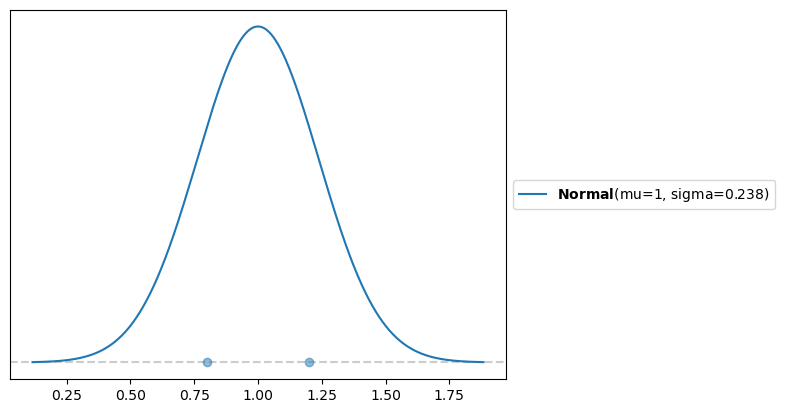

In [15]:
elicited_prior_pz, _ = pz.maxent(pz.Normal(), 0.8, 1.2, 0.6);

Once defined, the elicited prior can be seamlessly converted into the `Prior` class from `PyMC` - a data type required for the prior configuration of `BayesLinearRegressor` model. 

We can then instantiate a new `BayesLinearRegressor` model using this elicited prior. 
Note that the other priors remain at their default values. 

In [16]:
elicited_prior = Prior("Normal", mu=elicited_prior_pz.mu, sigma=elicited_prior_pz.sigma)

bayes_model = BayesianLinearRegressor(prior_config={"intercept": elicited_prior})
bayes_model.fit(X_train, y_train)

The model assumes that the intercept and slopes are independent. 
            Modify the model if this assumption doesn't apply!
instantiated BayesianLinearRegressor with the following priors:
  - intercept: Prior("Normal", mu=1.0000659133714382, sigma=0.23763668100677832)
  - slopes: Prior("Normal", mu=0, sigma=100, dims="pred_id")
  - noise_var: Prior("HalfCauchy", beta=5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=1.0000659133714382, sigma=0.23763668100677832),
                                      'noise_var': Prior("HalfCauchy", beta=5),
                                      'slopes': Prior("Normal", mu=0, sigma=100, dims="pred_id")},
                        sampler_config={'chains': 2, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

## Likelihood



The likelihood function $P(D \mid \theta)$ represents how likely it is to observe the given data, $D$, given a set of parameters $\theta$.

For linear regression, we are assume that each observed data point $y_i$ is normally distributed around its predicted value $\beta_0 + X_i \beta$, with variance $\sigma^2$.
    
$$P(D \mid \beta, \sigma) = \prod_{i=1}^{n} \mathcal{N}(y_i \mid \beta_0 + X_i \beta, \sigma^2)$$

where:

- $y_i$ are the observed target values,
- $X_i$ are the observed feature values,
- $\beta_0$ is the intercept,
- $\beta$ are the slopes/regression coefficients for the features,
- $\sigma$ is the standard deviation of the errors.


## Posterior

The posterior distribution, denoted as $P(\theta \mid D)$, represents the updated beliefs about the parameters $\theta$ after observing the data $D$. PyMC obtains the posterior distribution using Markov Chain Monte Carlo (MCMC) algorithms, which iteratively explore the parameter space, generating a sequence of samples that approximate the posterior distribution.

We can extract the posterior using the `sample_posterior` method of the `bayes_model`. 

In [17]:
posterior_samples = bayes_model.sample_posterior("numpy")

By plotting the posterior distributions, we observe two key points:
- The posterior distributions are much narrower than the initial priors, showing that the data has significantly refined our estimates.
- The posterior means, also known as Bayesian estimates, are closer to the true values than the MLE estimates from OLS. This improvement is due to the well-specified informative prior for the intercept

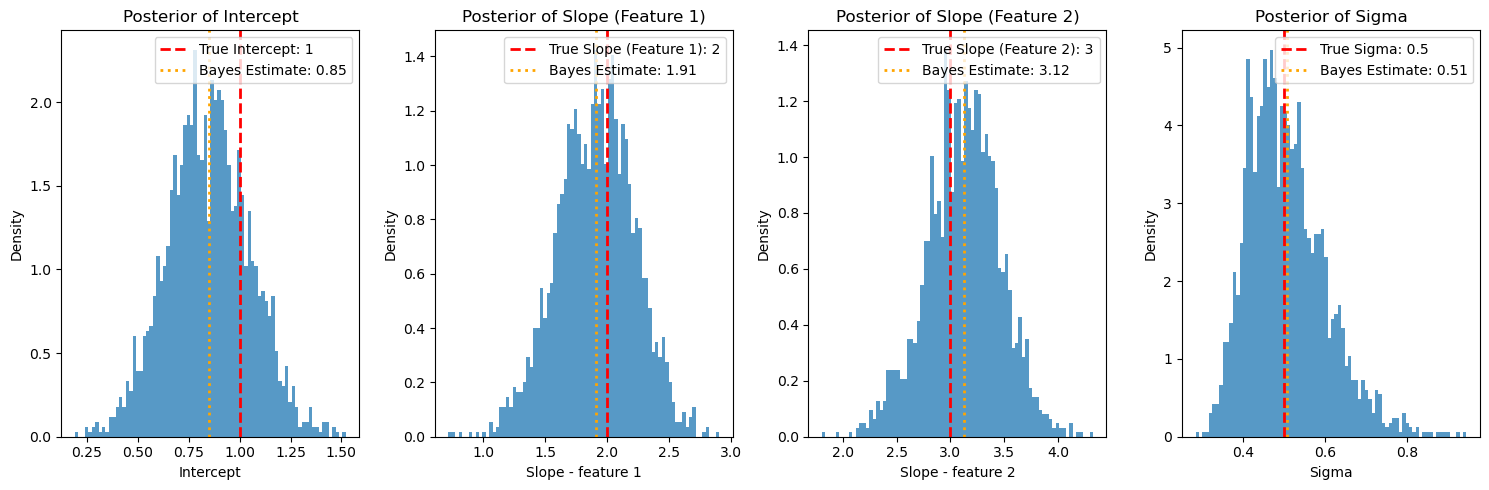

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Same figsize as the prior plot

# Calculate Bayesian estimates (mean of posterior)
bayes_estimate_intercept = posterior_samples["intercept"].mean()
bayes_estimate_slope1 = posterior_samples["slopes_feature1"].mean()
bayes_estimate_slope2 = posterior_samples["slopes_feature2"].mean()
bayes_estimate_sigma = posterior_samples["noise"].mean()

# Plot posterior for intercept
axes[0].hist(posterior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].axvline(
    TRUE_INTERCEPT,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Intercept: {TRUE_INTERCEPT}",
)
axes[0].axvline(
    bayes_estimate_intercept,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_intercept:.2f}",
)
axes[0].set_title("Posterior of Intercept")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")
axes[0].legend()

# Plot posterior for slope feature 1
axes[1].hist(posterior_samples["slopes_feature1"], bins=80, density=True, alpha=0.75)
axes[1].axvline(
    TRUE_SLOPES[0],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Slope (Feature 1): {TRUE_SLOPES[0]}",
)
axes[1].axvline(
    bayes_estimate_slope1,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_slope1:.2f}",
)
axes[1].set_title("Posterior of Slope (Feature 1)")
axes[1].set_xlabel("Slope - feature 1")
axes[1].set_ylabel("Density")
axes[1].legend()

# Plot posterior for slope feature 2
axes[2].hist(posterior_samples["slopes_feature2"], bins=80, density=True, alpha=0.75)
axes[2].axvline(
    TRUE_SLOPES[1],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Slope (Feature 2): {TRUE_SLOPES[1]}",
)
axes[2].axvline(
    bayes_estimate_slope2,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_slope2:.2f}",
)
axes[2].set_title("Posterior of Slope (Feature 2)")
axes[2].set_xlabel("Slope - feature 2")
axes[2].set_ylabel("Density")
axes[2].legend()

# Plot posterior for sigma (noise)
axes[3].hist(posterior_samples["noise"], bins=80, density=True, alpha=0.75)
axes[3].axvline(
    TRUE_SIGMA,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Sigma: {TRUE_SIGMA}",
)
axes[3].axvline(
    bayes_estimate_sigma,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_sigma:.2f}",
)
axes[3].set_title("Posterior of Sigma")
axes[3].set_xlabel("Sigma")
axes[3].set_ylabel("Density")
axes[3].legend()

plt.tight_layout()
plt.show()

We can make use of `get_posterior_summary()` to print out the summary statistics of our posterior.
Note the low values of the standard deviation - indicating the 'spikiness' of our distributions!

In [19]:
bayes_model.get_posterior_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.847,0.203,0.475,1.230,0.006,0.005,1005.0,1053.0,1.0
slopes[feature1],1.908,0.311,1.341,2.492,0.009,0.006,1265.0,1445.0,1.0
slopes[feature2],3.121,0.340,2.414,3.709,0.010,0.007,1099.0,831.0,1.0
noise_var,0.266,0.105,0.103,0.446,0.003,0.003,997.0,1015.0,1.0
noise,0.507,0.095,0.343,0.682,0.003,0.002,997.0,1015.0,1.0


Additionally, note that apart from using the convenience functions provided by the BayesianLinearRegressor, such as `get_posterior_summary`, you can directly access the `idata` attribute of the model instance. This 'idata' object is a container for all inference data we've used on this model so far, including the training data, the prior and the posterior. 

Once you have the `idata` object, you can use the `arviz` library to analyze and visualize any distributions created during the model's lifetime, such as the prior and posterior distributions. `arviz` provides a rich set of tools for diagnostics, plotting, and summarizing the results of Bayesian models. This allows for a thorough examination of the model's behavior and the reliability of the inferred parameters.

For example, here, we use `arviz`'s `plot_posterior` to plot the posterior distribution of the `intercept ` variable.

<Axes: title={'center': 'intercept'}>

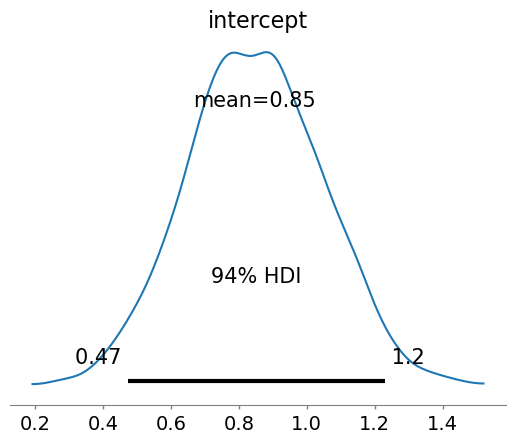

In [20]:
az.plot_posterior(bayes_model.idata, var_names="intercept")

# References



- [How to use the posterior predictive distribution for checking a model in PyMC](https://discourse.pymc.io/t/how-to-use-the-posterior-predictive-distribution-for-checking-a-model-from-pymc/11593/9) - A discussion on how to leverage posterior predictive checks in PyMC.
  
- [PyMC documentation: `sample_prior_predictive`](https://www.pymc.io/projects/docs/en/v5.15.1/api/generated/pymc.sample_prior_predictive.html) - Official PyMC documentation for generating samples from the prior predictive distribution.

- [Bishop - Pattern Recognition and Machine Learning (2006)](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) - A comprehensive reference on machine learning theory and Bayesian methods by Christopher M. Bishop.

- [Updating priors](https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html)